In [77]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LeakyReLU, Dropout, Dense, ReLU
from tensorflow.keras.models import Sequential
import seaborn as sns

In [78]:
data = pd.read_csv(r"E:\diploma\code\kc_house_data.csv")
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [79]:
data = data.drop_duplicates()
print(data.isnull().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


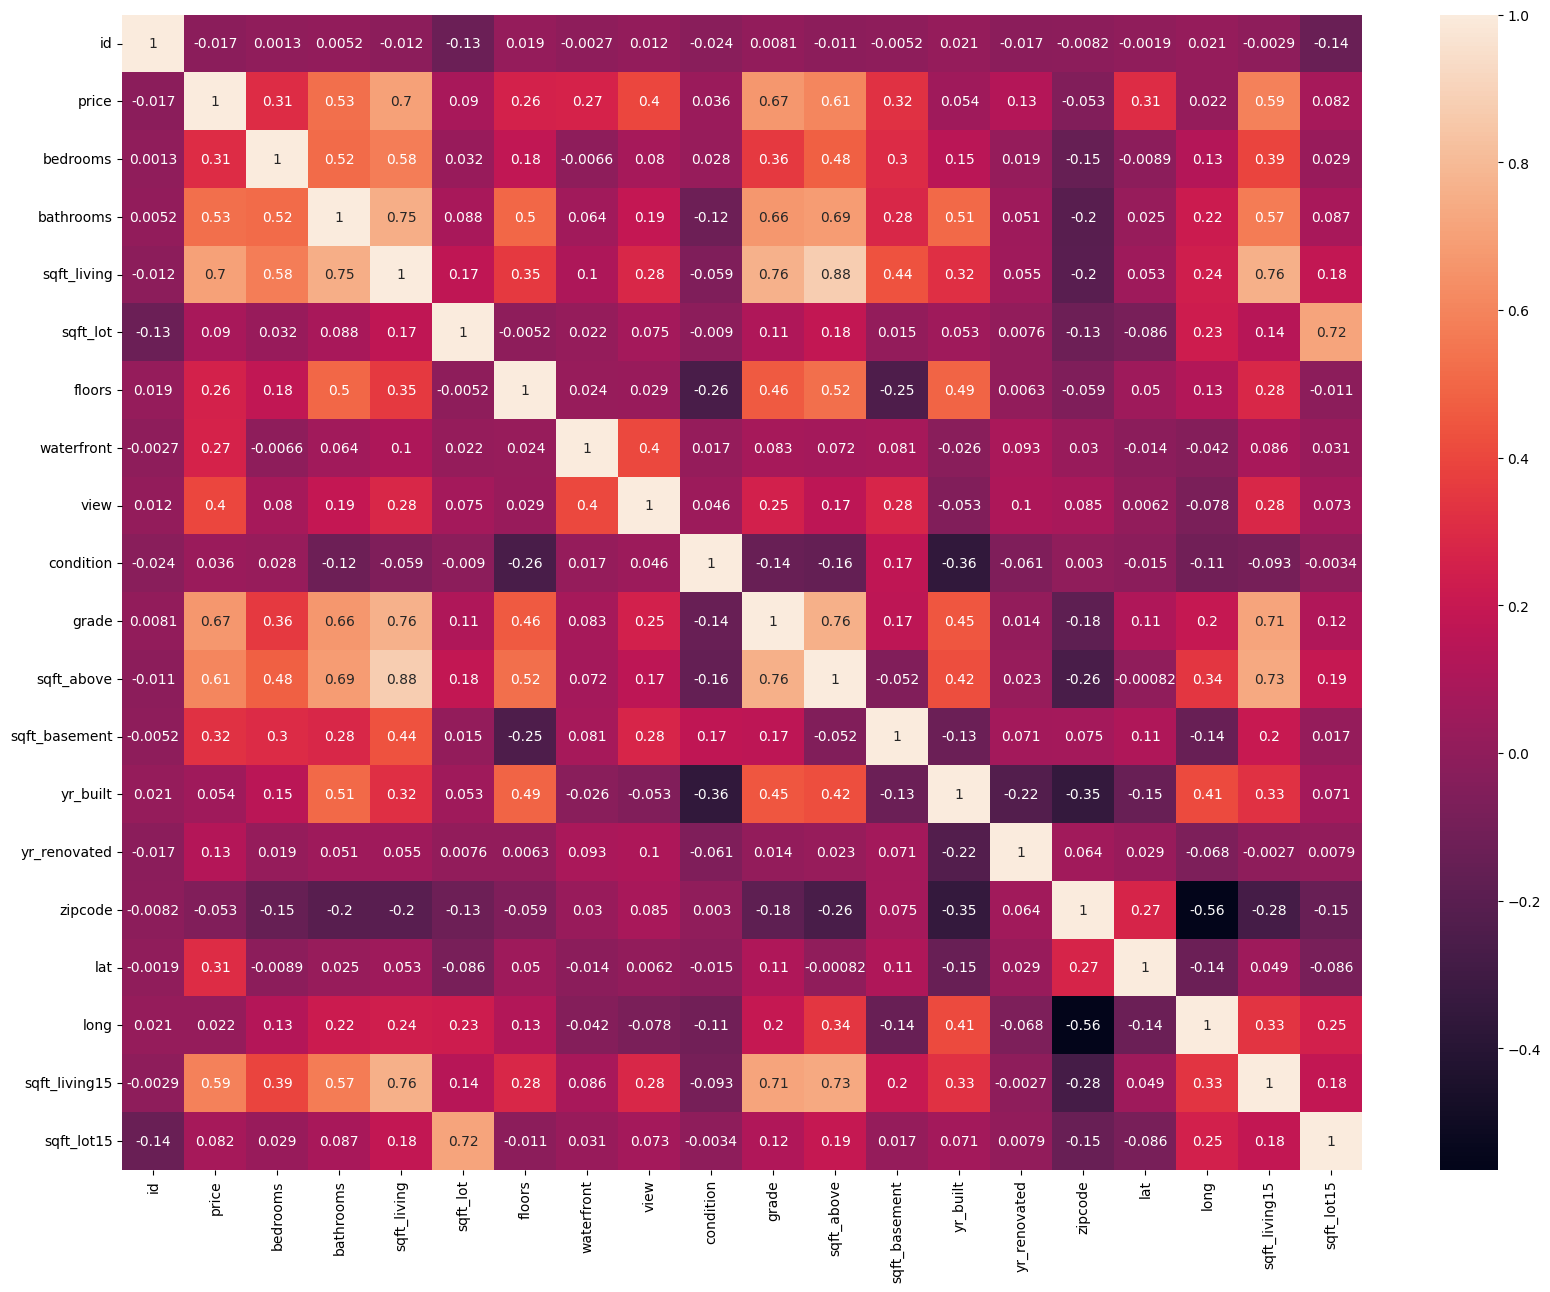

In [80]:
cormap = data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(cormap, annot=True)
plt.show()

In [81]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

data = data.drop("date",axis=1)

data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [82]:
def convert_to_dummy(value):
    if value == 0:
        return 0
    else:
        return 1
data['yr_renovated']=data['yr_renovated'].apply(convert_to_dummy)
data['sqft_basement']=data['sqft_basement'].apply(convert_to_dummy)
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1,98125,47.7210,-122.319,1690,7639,2014,12,9
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [83]:
def detect_outliers(x, c=1.5):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = (q3 - q1)
    lob = q1 - (iqr * c)
    uob = q3 + (iqr * c)
    indicies = np.where((x > uob) | (x < lob))
    return indicies


priceOutliers = detect_outliers(data['price'])
print("Total Outliers count : ", len(priceOutliers[0]))

data = data.drop(priceOutliers[0])

Total Outliers count :  1146


In [84]:
data['sqft_lot'] = data['sqft_lot'] + data['sqft_lot15']
data['sqft_living'] = data['sqft_living'] + data['sqft_living15']

In [85]:
features = data.drop(
    ['price', 'id', 'sqft_living15', 'sqft_lot15', 'zipcode', 'sqft_above',
     'waterfront','lat','long','sqft_basement', 'yr_renovated', "day", "year", "month"], axis=1)
target = data['price']

In [86]:
# Feature scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Train-test split
train_features, test_features, train_target, test_target = train_test_split(scaled_features, target, test_size=0.2,
                                                                            random_state=42)

In [87]:
train_features = tf.convert_to_tensor(train_features, dtype=tf.float32)
test_features = tf.convert_to_tensor(test_features, dtype=tf.float32)
train_target = tf.convert_to_tensor(train_target.values.reshape(-1, 1), dtype=tf.float32)
test_target = tf.convert_to_tensor(test_target.values.reshape(-1, 1), dtype=tf.float32)

In [88]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=9))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(train_features, train_target, epochs=300, batch_size=256, verbose=1, validation_data=(test_features, test_target))


[477755.84375, 477747.625, 477721.5625, 477655.4375, 477513.0, 477239.8125, 476759.71875, 475966.53125, 474719.5625, 472841.0, 470103.625, 466222.5625, 460858.03125, 453610.875, 443980.125, 431398.53125, 415191.46875, 394654.4375, 368887.0625, 337054.34375, 298322.625, 252941.25, 206185.09375, 169959.25, 150192.265625, 148144.671875, 148198.609375, 147518.1875, 146847.71875, 146301.3125, 145642.765625, 145100.515625, 144322.71875, 143740.375, 143116.828125, 142420.578125, 141806.953125, 141174.828125, 140596.59375, 139893.09375, 139290.578125, 138710.265625, 137973.734375, 137415.90625, 136665.546875, 135895.34375, 135356.453125, 134636.265625, 133851.71875, 133235.90625, 132464.078125, 131760.109375, 130985.3125, 130348.6171875, 129690.2421875, 128976.125, 128137.9765625, 127511.984375, 126768.7109375, 125926.1640625, 125133.0859375, 124388.8203125, 123585.96875, 122766.1953125, 122037.484375, 121315.203125, 120456.75, 119692.25, 119036.9609375, 118403.4296875, 117724.390625, 117148.3

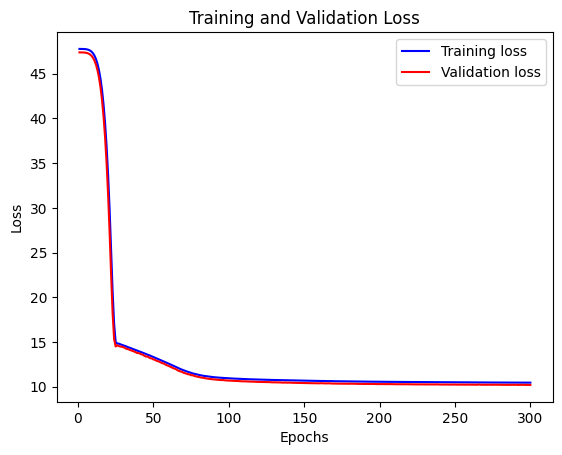

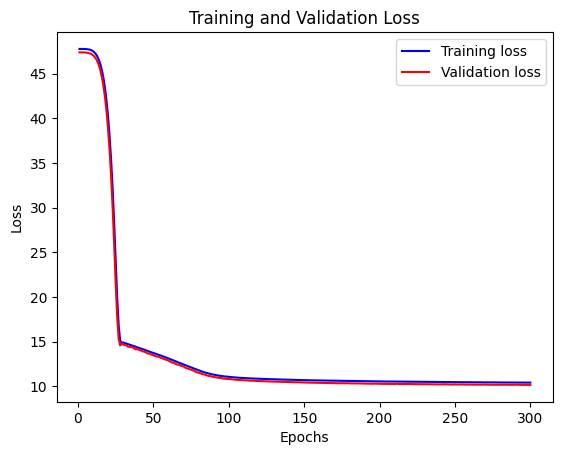

In [90]:
train_acc = history.history['mae']
val_acc = history.history['val_mae']
# Отримайте кількість епох
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
score = model.evaluate(test_features, test_target, verbose=0)
print('MSE:', score[0])
print('MAE:', score[1])

MSE: 171.3424
MAE: 10.168


In [92]:
new_data = pd.DataFrame({
    'bedrooms': [3],
    'bathrooms': [1],
    'sqft_living': [1180],
    'sqft_lot': [5650],
    'floors': [1],
    'view': [0],
    'condition': [3],
    'grade': [7],
    'yr_built': [1955],

})
new_data = scaler.transform(new_data)
prediction = model.predict(tf.convert_to_tensor(new_data, dtype=tf.float32))
print(f'Predicted Price: {prediction[0][0]}')



1/1 [==============================] - 0s 73ms/step
Predicted Price: 229264.765625
1/1 [==============================] - 0s 65ms/step
Predicted Price: 225130.015625
128/128 [==============================] - 0s 1ms/step
